In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mp_api.client import MPRester

from pymatgen.core import Composition, Element
from pymatgen.analysis.phase_diagram import GrandPotentialPhaseDiagram, PhaseDiagram, PDPlotter
from pymatgen.analysis.interface_reactions import InterfacialReactivity, GrandPotentialInterfacialReactivity
from pymatgen.io.vasp import Vasprun
from pymatgen.entries.compatibility import MaterialsProject2020Compatibility
from pymatgen.entries.computed_entries import ComputedEntry
from collections import defaultdict

import re
import sympy as sp




In [2]:
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D



In [3]:
import contextlib
import io, sys
import siman  # program package to manage DFT calculations https://github.com/dimonaks/siman
from siman.calc_manage import smart_structure_read, get_structure_from_matproj
from siman.calc_manage import add, res
from siman import header
from siman.database import write_database, read_database
from siman.set_functions import read_vasp_sets
from siman.header import db
from siman.header import _update_configuration
from pydoc import importfile
from siman import thermo
from matplotlib import rc
import matplotlib.pyplot as plt

# Suppress output (replaces %%capture)
with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    # Update configurations
    _update_configuration('./project_conf.py')
    read_database()  # read saved database if available
    
    project_sets = importfile('./project_sets.py')
    varset = read_vasp_sets(project_sets.user_vasp_sets, override_global=1)  # read user sets

    # Set paths
    # header.PATH2PROJECT = '../dft_calculations/'
    header.PATH2EDITOR = 'notepad.exe'
    header.PATH2POTENTIALS = "/home/a.burov/soft/vasp_potentials/potpaw_PBE_MPIE/"

    # Matplotlib settings (commented out as they're for interactive use)
    plt.rcParams['figure.dpi'] = 450

In [4]:
# polyhedra:
# shiness 100
# V: 229 25 0 204
# P: 192 156 194 204

# Edges: 180



In [276]:
colors_rgb = {
    #  "Li": (179, 222, 195), 
    # "La": (150, 150, 150), 
    # "Zr": (160, 160, 255), 
    # "O": (251, 155, 155), 

    # "Na": (255, 220, 155),
    # "Ga": (252, 170, 224), 
    # "P": (203, 174, 255),
    # "S": (117, 221, 255),
    # "C": (245, 173, 100),
  
    # "B": (1, 1, 1),  
    # "R": (255, 0, 0),  
    #  "N": (101, 83, 176),
    # "K": (255, 142, 185),

    "Na": (249, 220, 60),
    "V": (229, 25, 0),
    "Al": (129, 178, 214),
    "P": (192, 156, 194),
    "O": (254, 3, 0),
    "F": (176, 185, 230),
    "R": (211, 134, 252),
    "N": (227, 187, 102),
    "L": (144, 207, 99),

    "O_dos": (212, 32, 32),
    "V_dos": (85, 139, 204),
    "Al_dos": (98, 200, 199),
    "F_dos": (145, 219, 105),

}





In [277]:
alpha = 0.5
colors_hist = {k: list(float(x)/255 for x in v) + [alpha] for k, v in colors_rgb.items()}
colors_hist = {k: tuple(v)for k, v in colors_hist.items()}

In [278]:
colors_rgb = {element: tuple(v/255 for v in rgb) for element, rgb in colors_rgb.items()}


In [279]:
color_list = [ np.array(color) for name, color in colors_rgb.items() if (name not in ["B", "R"]) ]


In [280]:
colors_num = len(color_list) - 1


In [281]:
def rgb_to_hex(rgb_tuple):
    """Convert an RGB tuple (0-1 range) to a hex string."""
    return "#{:02x}{:02x}{:02x}".format(
        int(rgb_tuple[0] * 255 ),
        int(rgb_tuple[1] * 255 ),
        int(rgb_tuple[2] * 255 )
    )

In [282]:
def blend_with_white(fg_rgb, alpha):
    """
    Blend an RGB color with given alpha over white background.

    Parameters:
        fg_rgb: tuple of (R, G, B), each 0-255
        alpha: float in [0, 1], opacity of foreground color

    Returns:
        tuple of (R, G, B) blended color over white background
    """
    bg_rgb = (255, 255, 255)  # white background
    blended = tuple(
        round(alpha * fg_c + (1 - alpha) * bg_c)
        for fg_c, bg_c in zip(fg_rgb, bg_rgb)
    )
    return blended
    

In [12]:
api_key = 'HbSHn48X1CSvBzRa4DOX5E9rhb5Tcc03'

In [13]:
def create_dataframe_from_calc(vasprun_path: str, calc_name: str, if_save: bool) -> None:
    """
        Inputs:
            vasprun_path - path to vasprun.xml
            calc_name - name to save a file
            if_save - save pandas dataframe as csv
        Returns:
            pandasDataframe - dataframe with the results
    """

    # Extraction of the calculation
    vasprun = Vasprun(vasprun_path)    
    # include structure so proper correction can be applied for oxides and sulfides
    reactant2 = vasprun.get_computed_entry(inc_structure=True)
    # reactant2.parameters['run_type'] = 'GGA+U'
    
    compatibility = MaterialsProject2020Compatibility()
    # compatibility.process_entry(reactant2)
    reactant2 = compatibility.process_entry(reactant2)

    reactant2.parameters['run_type'] = 'GGA_GGA+U'
    # reactant2.parameters['run_type'] = 'GGA+U'
    # reactant2.parameters['run_type'] = 'GGA+U'

    # Find coatings 
    comps = []
    emins = []
    reactions = []
    
    with MPRester(api_key=api_key) as mpr:
        for comp in tqdm(cathode_coatings.formula_pretty.unique()):
            try:
                # Is the system open to an elemental reservoir?
                grand = False
    
                if grand:
                    # Element in the elemental reservoir.
                    open_el = "Na" 
                    # Relative chemical potential vs. pure substance. Must be non-positive.
                    relative_mu = 3.25 # average intercalation potential
    
    
                # Get the compositions of the reactants
                reactant1 = comp
    
                comp1 = Composition(reactant1)
                comp2 = reactant2.composition # as it is manually calculated phase
    
                # Gather all elements involved in the chemical system.
                # elements = [e.symbol for e in comp1.elements + comp2.elements]
                elements = [e.symbol for e in comp1.elements + comp2.elements]
                
                if grand:
                    elements.append(open_el)
                elements = list(set(elements))  # Remove duplicates
    
                entries = mpr.get_entries_in_chemsys(elements, additional_criteria={'thermo_types': ['GGA_GGA+U', "R2SCAN"]})

                # Apply corrections locally with the mixing scheme
                scheme = MaterialsProjectDFTMixingScheme()
                corrected_entries = scheme.process_entries(entries)
    
                # Build a phase diagram using these entries.
                phase_diagram = PhaseDiagram(entries)
    
                # For an open system, include the grand potential phase diagram.
                if grand:
                    # Get the chemical potential of the pure subtance.
                    mu = phase_diagram.get_transition_chempots(Element(open_el))[0]
                    # Set the chemical potential in the elemental reservoir.
                    chempots = {open_el: relative_mu + mu}
                    # Build the grand potential phase diagram
                    gpd = GrandPotentialPhaseDiagram(entries, chempots)
                    # Create InterfacialReactivity object.
                    interface = GrandPotentialInterfacialReactivity(
                        comp1,
                        comp2,
                        gpd,
                        norm=True,
                        # include_no_mixing_energy=True,
                        include_no_mixing_energy=False,
                        pd_non_grand=phase_diagram,
                        use_hull_energy=True,
                    )
                    
                else:
                    interface = InterfacialReactivity(
                        comp1,
                        comp2,
                        phase_diagram,
                        norm=True,
                        include_no_mixing_energy=False,
                        # include_no_mixing_energy=False,
                        pd_non_grand=None,
                        use_hull_energy=True,
                    )
                    
                interface_table = interface.get_dataframe()
                emins.append(interface.get_dataframe()['E$_{\textrm{rxn}}$ (eV/atom)'].min())
                comps.append(comp)
                index = np.argmin(interface_table['E$_{\textrm{rxn}}$ (eV/atom)'].values)
                reactions.append(interface_table['Reaction'].iloc[index])
            except:
                continue

    res = pd.DataFrame()
    res['formula_pretty'] = comps
    res[f'e_rxn_{calc_name}_CC'] = emins
    res[f'interface_reaction_{calc_name}'] = reactions

    if if_save:
        res.merge(cathode_coatings).round(3).to_csv(f'data_nmc/{calc_name}_CC_calculation_results.csv', index = False)
        
    return res
    
    
    


In [ ]:
# Path to vasprun.xml file
vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_inter.xml"



In [ ]:
# Parse vasprun.xml
vasprun = Vasprun(vasprun_path)

# Get final energy
final_energy = vasprun.final_energy
print(f"Final energy: {final_energy} eV")


In [ ]:
vasprun.final_structure.num_sites

In [ ]:
# Access the structure
structure = vasprun.final_structure
# print(structure)


## Thermodynamic stability

In [183]:
from pymatgen.entries.compatibility import MaterialsProjectCompatibility


In [184]:
def balance_reaction_one_reactant_any_products(reactants, products):
    # Get the single reactant name and atom counts
    reactant_name = next(iter(reactants))
    reactant_counts = reactants[reactant_name]

    # Collect unique elements from reactant and all products
    elements = sorted(set(reactant_counts.keys()).union(
        el for p in products.values() for el in p.keys()
    ))

    # Create sympy variables: one for reactant 'a' and one for each product
    a = sp.symbols('a')
    product_vars = sp.symbols(f'b0:{len(products)}')

    # Build balance equations for each element
    equations = []
    for el in elements:
        lhs = a * reactant_counts.get(el, 0)  # reactant side
        rhs = sum(product_vars[i] * p.get(el, 0) for i, p in enumerate(products.values()))
        equations.append(sp.Eq(lhs, rhs))

    # Solve for product coefficients in terms of 'a'
    vars_to_solve = list(product_vars)
    solutions = sp.solve(equations, vars_to_solve, dict=True)
    if not solutions:
        raise ValueError("No solution found to balance the equation.")
    sol = solutions[0]
    sol[a] = a  # keep 'a' free

    # Substitute a=1 to get numeric coefficients
    coeffs = {a: 1}
    coeffs.update({var: sol[var].subs(a, 1) for var in product_vars})

    # Normalize coefficients to smallest integers
    def to_int_fraction(x):
        if isinstance(x, int):
            return x, 1
        else:
            p, q = x.as_numer_denom()
            return int(p), int(q)

    nums_dens = [to_int_fraction(v) for v in coeffs.values()]
    from math import gcd
    from functools import reduce

    def lcm(x, y):
        return x * y // gcd(x, y)

    common_den = reduce(lcm, (d for _, d in nums_dens), 1)
    scaled = [n * (common_den // d) for n, d in nums_dens]
    gcd_all = reduce(gcd, scaled)
    normalized = [s // gcd_all for s in scaled]

    # Prepare output dictionary with species names and their coefficients
    balanced_coeffs = {reactant_name: normalized[0]}
    for i, pname in enumerate(products):
        balanced_coeffs[pname] = normalized[i + 1]

    return balanced_coeffs



In [185]:
def parse_formula(formula):
    pattern = r'([A-Z][a-z]?)(\d*)|(\()|(\))(\d*)'
    matches = list(re.finditer(pattern, formula))
    
    stack = [defaultdict(int)]
    
    for match in matches:
        element, count, open_paren, close_paren, paren_count = match.groups()
        
        if element:
            cnt = int(count) if count else 1
            stack[-1][element] += cnt
        
        elif open_paren:
            stack.append(defaultdict(int))
        
        elif close_paren:
            cnt = int(paren_count) if paren_count else 1
            group = stack.pop()
            for elem, num in group.items():
                stack[-1][elem] += num * cnt
    
    return dict(stack.pop())




In [200]:
# Path to vasprun.xml file
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_inter.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_deinter.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_some_na.xml"

# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al_some_na.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al_some_na_dead.xml"

vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al_li.xml"



In [201]:
# Parse vasprun.xml
vasprun = Vasprun(vasprun_path)

# Get final energy
final_energy = vasprun.final_energy
print(f"Final energy: {final_energy} eV")


ParseError: not well-formed (invalid token): line 354, column 0 (<string>)

In [202]:
comp_entry = ComputedEntry(vasprun.final_structure.composition, vasprun.final_energy)


In [203]:
elements = [el.symbol for el in comp_entry.elements]  # elements in your compound

with MPRester(api_key) as mpr:
    entries = mpr.get_entries_in_chemsys(elements)  # all known phases in this system

    

Retrieving ThermoDoc documents:   0%|          | 0/1365 [00:00<?, ?it/s]

In [204]:
compat = MaterialsProjectCompatibility()
# MaterialsProject2020Compatibility
entries = compat.process_entries(entries)

# Also process your entry with the same corrections
# entry = compat.process_entry(comp_entry)


/tmp/ipykernel_69623/992659018.py:1: DeprecationWarning: MaterialsProjectCompatibility is deprecated; use MaterialsProject2020Compatibility instead.
Materials Project formation energies use the newer MaterialsProject2020Compatibility scheme.
  compat = MaterialsProjectCompatibility()


In [205]:
st_names = {
        "mp-1238774": 'navpo4f',
        # "mp-25440": 'vpo4f',     
        "mp-686540": 'na3al2p2o8f3',     
        "mp-7848": 'alpo4',     
        "mp-19291": 'navpo5',     
        "mp-468": 'alf3',     
        "mp-559931": 'vf3',     
        "mp-1094113": 'NaV2P2O9',     
        "mp-1104878": 'VPO4F',     
        "mp-17999": 'NaVF4',     
        "mp-752810": 'NaVP2O7',     
        "mp-694937": 'Na3V2P2O8F3',     
        "mp-18835": 'VPO4',     
        "mp-25265": 'VPO5',     
        "mp-26728": 'VP2O7',     
        "mp-1102077": 'NaAlF4',     
       }


In [216]:
for key, val in st_names.items():
    name_calc = st_names[key]
    en_react = db[name_calc, '9_bulk_mp', 1].e0_at

    with MPRester(api_key) as mpr:
        docs = mpr.materials.summary.search(
            material_ids=[key]
        )

    example_doc = docs[0]
    sg = example_doc.structure.get_space_group_info()

    print(key, val, sg, round(en_react,3), )

    
    

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-1238774 navpo4f ('Pna2_1', 33) -7.07


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-686540 na3al2p2o8f3 ('Cmc2_1', 36) -6.453


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-7848 alpo4 ('I-4', 82) -7.486


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-19291 navpo5 ('P2_1/c', 14) -7.361


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-468 alf3 ('R-3c', 167) -5.882


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-559931 vf3 ('P-1', 2) -6.555


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-1094113 NaV2P2O9 ('Pnma', 62) -7.631


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-1104878 VPO4F ('C2/c', 15) -7.506


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-17999 NaVF4 ('P2_1/c', 14) -5.854


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-752810 NaVP2O7 ('P2_1', 4) -7.341


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-694937 Na3V2P2O8F3 ('Pnnm', 58) -6.777


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-18835 VPO4 ('Cmcm', 63) -7.931


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-25265 VPO5 ('Pnma', 62) -7.828


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-26728 VP2O7 ('P-1', 2) -7.662


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mp-1102077 NaAlF4 ('Cmcm', 63) -5.416


In [206]:
all_entries = entries + [comp_entry]
pd = PhaseDiagram(all_entries)

decomp, e_above_hull = pd.get_decomp_and_e_above_hull(comp_entry)

reactants = {vasprun.final_structure.reduced_formula: parse_formula(vasprun.final_structure.reduced_formula)}
reactant_name = next(iter(reactants))
reactant_at = sum(reactants[reactant_name].values())

products = {}

print(f"Energy above hull: {e_above_hull:.4f} eV/atom")
if e_above_hull == 0:
    print("Phase is thermodynamically stable")
elif e_above_hull < 0.05:
    print("Phase is metastable")
else:
    print("Phase decomposes to:")
    for entry, amount in decomp.items():
        mp_id = getattr(entry, "entry_id", "N/A")
        products[entry.composition.reduced_formula] = parse_formula(entry.composition.reduced_formula)
        print(f"{amount:.3f}*{entry.composition.reduced_formula} + ", end="")

    bal = balance_reaction_one_reactant_any_products(reactants, products)
    
    print()
    coeff_react = bal[reactant_name]
    en_decomp = (vasprun.final_energy / vasprun.final_structure.num_sites) * reactant_at * coeff_react
    for entry, amount in decomp.items():
        mp_id = getattr(entry, "entry_id", "N/A")
        mp_id_parse = mp_id.split('-GGA')[0]
        react_name = entry.composition.reduced_formula
        coeff_prod = bal[react_name]
        name_calc = st_names[mp_id_parse]
        en_react = db[name_calc, '9_bulk_mp', 1].e0_at
        product_at = sum(products[entry.composition.reduced_formula].values())
        en_decomp -= en_react * product_at * coeff_prod

        print(f"  {entry.composition.reduced_formula} (MP-ID: {mp_id}) : {amount:.3f}")


    en_decomp /= (reactant_at * coeff_react)
    # en_decomp /= (reactant_at)
    
    print(f"Decomposition energy is {en_decomp*1000:.0f} meV/atom")

        

Energy above hull: 0.4022 eV/atom
Phase decomposes to:
0.571*Na3V2P2O8F3 + 0.048*NaAlF4 + 0.381*VPO4 + 
  Na3V2P2O8F3 (MP-ID: mp-694937-GGA+U) : 0.571
  NaAlF4 (MP-ID: mp-1102077-GGA) : 0.048
  VPO4 (MP-ID: mp-18835-GGA+U) : 0.381
Decomposition energy is 28 meV/atom


In [207]:
coeff_react

1

In [208]:
bal


{'Na13AlV16P16(O4F)16': 1, 'Na3V2P2O8F3': 4, 'NaAlF4': 1, 'VPO4': 8}

In [ ]:
with MPRester(api_key) as mpr:
    docs = mpr.materials.summary.search(
        material_ids=["mp-149",]
    )

    

## RDF

In [14]:
from ovito.io import import_file
from ovito.modifiers import CoordinationAnalysisModifier, VoronoiAnalysisModifier, SelectTypeModifier
from ovito.data import DataCollection  # Or your pipeline's compute output type




/home/arseniy/micromamba/envs/default/lib/python3.12/site-packages/ovito/_extensions/anari.py:2: UserWarning: Did you accidentally install the OVITO package from the PyPI repository in an Anaconda/Miniconda Python interpreter using the 'pip' command? This will likely lead to conflicts with existing libraries in the Anaconda environment, and import of the OVITO module may fail with an error related to the Qt framework. To fix this, please uninstall the ovito pip package by running 'pip uninstall -y ovito PySide6' and then install the OVITO Anaconda package provided by OVITO GmbH. Visit https://docs.ovito.org/python/introduction/installation.html for further instructions. If you would rather like to ignore this warning message, add the following code to the top of your Python script:

  import warnings
  warnings.filterwarnings('ignore', message='.*OVITO.*PyPI')

  import ovito._extensions.pyscript


In [15]:
def calculate_average_rdf(pipeline, li_type_id=1, o_type_id=4, cutoff=7.0, number_of_bins=200):
    """Calculate average RDF and standard deviation across all frames"""
    # Initialize storage
    all_li_o_rdf = []
    all_li_li_rdf = []
    distances = None
    
    # Process each frame
    for frame in tqdm(range(pipeline.source.num_frames), desc="Processing frames"):
        pipeline.modifiers.clear()
        
        # Select only Li and O atoms
        pipeline.modifiers.append(SelectTypeModifier(
            property='Particle Type',
            types={li_type_id, o_type_id}
        ))
        
        # RDF analysis
        pipeline.modifiers.append(CoordinationAnalysisModifier(
            cutoff=cutoff,
            number_of_bins=number_of_bins,
            partial=True
        ))
        
        data = pipeline.compute(frame)
        rdf_table = data.tables['coordination-rdf']
        xy_data = rdf_table.xy()
        component_names = rdf_table.y.component_names
        
        # Store distances (same for all frames)
        if distances is None:
            distances = xy_data[:, 0]
        
        # Extract Li-O and Li-Li RDFs
        li_o_rdf = None
        li_li_rdf = None
        
        for i, name in enumerate(component_names):
            if name == f"{li_type_id}-{o_type_id}" or name == f"{o_type_id}-{li_type_id}":
                li_o_rdf = xy_data[:, i+1]
            elif name == f"{li_type_id}-{li_type_id}":
                li_li_rdf = xy_data[:, i+1]
        
        if li_o_rdf is not None:
            all_li_o_rdf.append(li_o_rdf)
        if li_li_rdf is not None:
            all_li_li_rdf.append(li_li_rdf)
    
    # Convert to numpy arrays
    li_o_rdfs = np.array(all_li_o_rdf)
    li_li_rdfs = np.array(all_li_li_rdf)
    
    # Calculate statistics
    results = {
        'Li-O': {
            'distances': distances,
            'mean': np.mean(li_o_rdfs, axis=0),
            'std': np.std(li_o_rdfs, axis=0),
            'all': li_o_rdfs
        },
        'Li-Li': {
            'distances': distances,
            'mean': np.mean(li_li_rdfs, axis=0),
            'std': np.std(li_li_rdfs, axis=0),
            'all': li_li_rdfs
        }
    }
    
    return results

def print_top_peaks(rdf_results, n_peaks=5):
    """Print positions and intensities of top RDF peaks with errors"""
    for correlation in ['Li-O', 'Li-Li']:
        print(f"\nTop {n_peaks} peaks for {correlation}:")
        print("-"*50)
        print(f"{'Peak':<10}{'Position (Å)':<15}{'Intensity':<15}{'± Error':<15}")
        print("-"*50)
        
        distances = rdf_results[correlation]['distances']
        mean_rdf = rdf_results[correlation]['mean']
        std_rdf = rdf_results[correlation]['std']
        
        # Find peaks (adjust prominence as needed)
        peaks, properties = find_peaks(mean_rdf, prominence=0.5)
        
        # Sort peaks by intensity (descending)
        sorted_peaks = sorted(zip(peaks, mean_rdf[peaks]), 
                            key=lambda x: x[1], reverse=True)
        
        # Print top n peaks
        for i, (peak_idx, intensity) in enumerate(sorted_peaks[:n_peaks]):
            pos = distances[peak_idx]
            error = std_rdf[peak_idx]
            print(f"{i+1:<10}{pos:<15.3f}{intensity:<15.3f}{error:<15.3f}")





In [170]:
def calculate_average_rdf(pipeline, frame=0, v_type_id=2, o_type_id=4, f_type_id=5, cutoff=7.0, number_of_bins=200):
    all_v_o_rdfs = []
    all_v_f_rdfs = []
    all_v_o_f_rdfs = []
    distances = None
    pipeline.modifiers.clear()
    # Select only V, O, and F atoms
    pipeline.modifiers.append(SelectTypeModifier(
        property='Particle Type',
        types={v_type_id, o_type_id, f_type_id}
    ))
    # RDF calculation modifier
    pipeline.modifiers.append(CoordinationAnalysisModifier(
        cutoff=cutoff,
        number_of_bins=number_of_bins,
        partial=True
    ))

    for frame in range(pipeline.num_frames):
        # print(frame)
        data = pipeline.compute(frame)
        rdf_table = data.tables['coordination-rdf']
        xy_data = rdf_table.xy()
        component_names = rdf_table.y.component_names
        
        if distances is None:
            distances = xy_data[:, 0]
        
        v_o_rdf = None
        v_f_rdf = None
    
        for i, name in enumerate(component_names):
            if name == 'V-O' or name == 'O-V':
                v_o_rdf = xy_data[:, i+1]
            elif name == 'V-F' or name == 'F-V':
                v_f_rdf = xy_data[:, i+1]
        
        # Calculate total RDF as sum of V-O and V-F
        v_o_f_rdf = None
        if v_o_rdf is not None and v_f_rdf is not None:
            v_o_f_rdf = v_o_rdf + v_f_rdf
        elif v_o_rdf is not None:
            v_o_f_rdf = v_o_rdf.copy()
        elif v_f_rdf is not None:
            v_o_f_rdf = v_f_rdf.copy()
    
        if v_o_rdf is not None:
            all_v_o_rdfs.append(v_o_rdf)
        if v_f_rdf is not None:
            all_v_f_rdfs.append(v_f_rdf)
        if v_o_f_rdf is not None:
            all_v_o_f_rdfs.append(v_o_f_rdf)
    
    import numpy as np
    
    results = {}
    if all_v_o_f_rdfs:
        v_o_f_rdfs_array = np.array(all_v_o_f_rdfs)
        results['V-O+V-F'] = {
            'distances': distances,
            'mean': np.mean(v_o_f_rdfs_array, axis=0),
            'std': np.std(v_o_f_rdfs_array, axis=0),
            'all': v_o_f_rdfs_array
        }
    if all_v_o_rdfs:
        v_o_rdfs_array = np.array(all_v_o_rdfs)
        results['V-O'] = {
            'distances': distances,
            'mean': np.mean(v_o_rdfs_array, axis=0),
            'std': np.std(v_o_rdfs_array, axis=0),
            'all': v_o_rdfs_array
        }
    if all_v_f_rdfs:
        v_f_rdfs_array = np.array(all_v_f_rdfs)
        results['V-F'] = {
            'distances': distances,
            'mean': np.mean(v_f_rdfs_array, axis=0),
            'std': np.std(v_f_rdfs_array, axis=0),
            'all': v_f_rdfs_array
        }
    

    
    return results


In [175]:
# Usage example:
# pipeline_inter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/inter.POSCAR")
pipeline_inter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/inter.XDATCAR")
results_inter = calculate_average_rdf(pipeline_inter)

# pipeline_deinter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/some_na.POSCAR")
pipeline_deinter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/deinter.XDATCAR")
results_deinter = calculate_average_rdf(pipeline_deinter)

# pipeline_al_inter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_dist.POSCAR")
pipeline_al_inter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al.dist.XDATCAR")
results_al_inter = calculate_average_rdf(pipeline_al_inter)

# pipeline_al_deinter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_some_na_dead.POSCAR")
pipeline_al_deinter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al_some_na.XDATCAR")
results_al_deinter = calculate_average_rdf(pipeline_al_deinter)

In [176]:
# results_al_inter

In [177]:
# Print statistics
print("\nRDF Statistics Low:")
print(f"V-O average first peak height: {np.max(results_inter['V-O']['mean']):.2f}")
print(f"F-O average first peak height: {np.max(results_inter['V-F']['mean']):.2f}")



RDF Statistics Low:
V-O average first peak height: 10.66
F-O average first peak height: 18.75


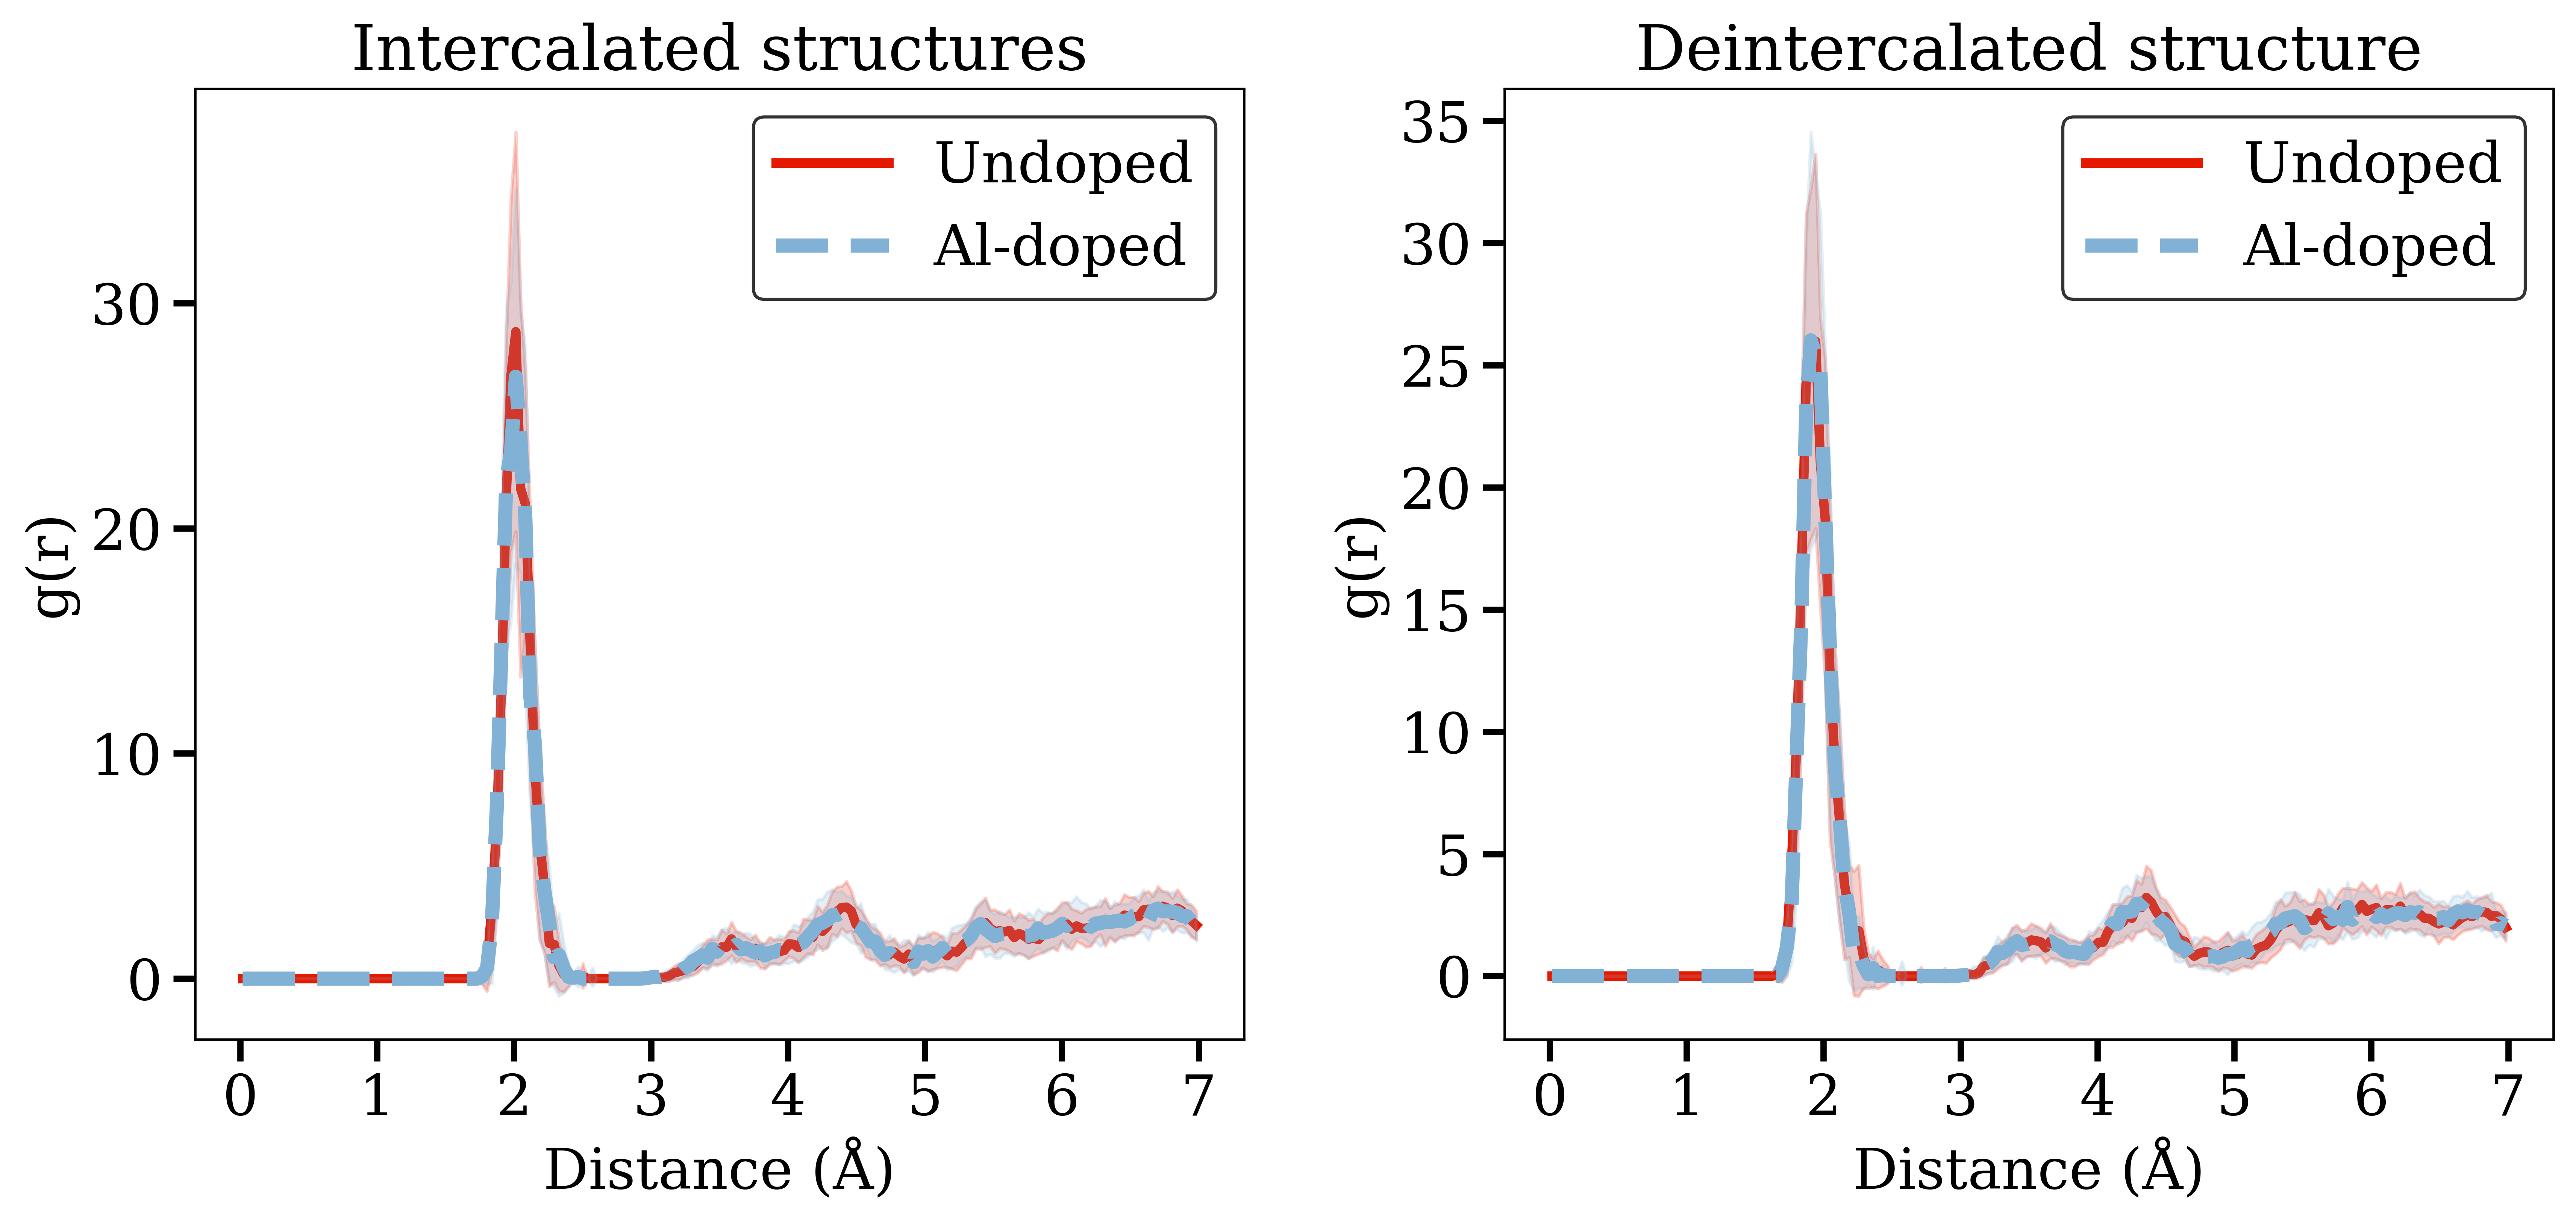

In [224]:
fontsize = 18
lw = 3.0
alpha = 0.20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=600)
plt.tight_layout()

# --- V-O subplot ---
dist_inter = results_inter['V-O+V-F']['distances']
mean_inter = results_inter['V-O+V-F']['mean']
std_inter = results_inter['V-O+V-F']['std']

dist_deinter = results_deinter['V-O+V-F']['distances']
mean_deinter = results_deinter['V-O+V-F']['mean']
std_deinter = results_deinter['V-O+V-F']['std']

dist_al_inter = results_al_inter['V-O+V-F']['distances']
mean_al_inter = results_al_inter['V-O+V-F']['mean']
std_al_inter = results_al_inter['V-O+V-F']['std']

dist_al_deinter = results_al_deinter['V-O+V-F']['distances']
mean_al_deinter = results_al_deinter['V-O+V-F']['mean']
std_al_deinter = results_al_deinter['V-O+V-F']['std']

ax1.plot(dist_inter, mean_inter, '-', color=colors_rgb["V"], label=r'Undoped', lw=lw, zorder=1)
ax1.fill_between(dist_inter, mean_inter-std_inter, mean_inter+std_inter, color=colors_rgb["V"], alpha=alpha)

ax1.plot(dist_al_inter, mean_al_inter, '--', color=colors_rgb["Al"], label=r'Al-doped', lw=lw*1.5, zorder=2)
ax1.fill_between(dist_al_inter, mean_al_inter-std_al_inter, mean_al_inter+std_al_inter, color=colors_rgb["Al"], alpha=alpha)

ax1.locator_params(axis='y', nbins=8)
ax1.locator_params(axis='x', nbins=8)
ax1.set_xlabel('Distance (Å)', fontsize=fontsize)
ax1.set_ylabel('g(r)', fontsize=fontsize)
ax1.set_title('Intercalated structures', fontsize=fontsize+2)
ax1.legend(loc=1, fontsize=fontsize, edgecolor="black")
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize-2)
ax1.yaxis.get_offset_text().set_fontsize(10)
ax1.xaxis.set_tick_params(width=2, length=7)
ax1.yaxis.set_tick_params(width=2, length=7)
# ax1.grid(alpha=0.3)


ax2.plot(dist_deinter, mean_deinter, '-', color=colors_rgb["V"], label=r'Undoped', lw=lw, zorder=1)
ax2.fill_between(dist_deinter, mean_deinter-std_deinter, mean_deinter+std_deinter, color=colors_rgb["V"], alpha=alpha)

ax2.plot(dist_al_deinter, mean_al_deinter, '--', color=colors_rgb["Al"], label=r'Al-doped', lw=lw*1.5, zorder=2)
ax2.fill_between(dist_al_deinter, mean_al_deinter-std_al_deinter, mean_al_deinter+std_al_deinter, color=colors_rgb["Al"], alpha=alpha)

ax2.locator_params(axis='y', nbins=8)
ax2.locator_params(axis='x', nbins=8)
ax2.set_xlabel('Distance (Å)', fontsize=fontsize)
ax2.set_ylabel('g(r)', fontsize=fontsize)
ax2.set_title('Deintercalated structure', fontsize=fontsize+2)
ax2.legend(loc=1, fontsize=fontsize, edgecolor="black")
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize-2)
ax2.yaxis.get_offset_text().set_fontsize(10)
ax2.xaxis.set_tick_params(width=2, length=7)
ax2.yaxis.set_tick_params(width=2, length=7)


plt.tight_layout()
plt.show()


fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/ratios.png", dpi=600, bbox_inches='tight')
fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/ratios.pdf", dpi=600, bbox_inches='tight')




In [21]:
def print_top_peaks(rdf_results, n_peaks=5):
    """Print positions and intensities of top RDF peaks with errors"""
    for correlation in ['V-O', 'V-F']:
        print(f"\nTop {n_peaks} peaks for {correlation}:")
        print("-"*50)
        print(f"{'Peak':<10}{'Position (Å)':<15}{'Intensity':<15}{'± Error':<15}")
        print("-"*50)
        
        distances = rdf_results[correlation]['distances']
        mean_rdf = rdf_results[correlation]['mean']
        std_rdf = rdf_results[correlation]['std']
        
        # Find peaks (adjust prominence as needed)
        peaks, properties = find_peaks(mean_rdf, prominence=0.05)
        
        # Sort peaks by intensity (descending)
        sorted_peaks = sorted(zip(peaks, mean_rdf[peaks]), 
                            key=lambda x: x[1], reverse=True)
        
        # Print top n peaks
        for i, (peak_idx, intensity) in enumerate(sorted_peaks[:n_peaks]):
            pos = distances[peak_idx]
            error = std_rdf[peak_idx]
            print(f"{i+1:<10}{pos:<15.3f}{intensity:<15.3f}{error:<15.3f}")

print("Low:")
print_top_peaks(results_low)

print("\n High:")
print_top_peaks(results_high)


Low:


NameError: name 'results_low' is not defined

In [22]:
# Usage example:
pipeline_low = import_file("./data/ga_400.lammpstrj")
results_low = calculate_average_rdf(pipeline_low)

pipeline_high = import_file("./data/ga_1300.lammpstrj")
results_high = calculate_average_rdf(pipeline_high)

# print_top_peaks(results)

# Print statistics
print("\nRDF Statistics Low:")
print(f"Li-O average first peak height: {np.max(results_low['Li-O']['mean']):.2f} ± {results_low['Li-O']['std'][np.argmax(results_low['Li-O']['mean'])]:.2f}")
print(f"Li-Li average first peak height: {np.max(results_low['Li-Li']['mean']):.2f} ± {results_low['Li-Li']['std'][np.argmax(results_low['Li-Li']['mean'])]:.2f}")

print("\nRDF Statistics High:")
print(f"Li-O average first peak height: {np.max(results_high['Li-O']['mean']):.2f} ± {results_high['Li-O']['std'][np.argmax(results_high['Li-O']['mean'])]:.2f}")
print(f"Li-Li average first peak height: {np.max(results_high['Li-Li']['mean']):.2f} ± {results_high['Li-Li']['std'][np.argmax(results_high['Li-Li']['mean'])]:.2f}")



RuntimeError: File does not exist: ./data/ga_400.lammpstrj

## Rotation of polyhedra

In [23]:
import numpy as np
from pymatgen.io.vasp import Poscar
from scipy.spatial.transform import Rotation


In [24]:
import numpy as np
from pymatgen.io.vasp import Poscar
from scipy.spatial.transform import Rotation

def get_polyhedra_bond_vectors(structure, central_element, neighbor_elements, cutoff):
    bond_vectors_list = []
    for site in structure.sites:
        if site.species_string == central_element:
            neighbors = structure.get_neighbors(site, cutoff)
            filtered = [n for n in neighbors if n.species_string in neighbor_elements]
            vectors = np.array([n.coords - site.coords for n in filtered])
            bond_vectors_list.append(vectors)
    return bond_vectors_list

def kabsch_rotation(P, Q):
    assert P.shape == Q.shape, f"Shapes must match: {P.shape} vs {Q.shape}"
    P_centroid = P.mean(axis=0)
    Q_centroid = Q.mean(axis=0)
    P_centered = P - P_centroid
    Q_centered = Q - Q_centroid
    C = Q_centered.T @ P_centered
    V, S, Wt = np.linalg.svd(C)
    d = np.sign(np.linalg.det(V) * np.linalg.det(Wt))
    if d < 0:
        V[:, -1] *= -1
    U = V @ Wt
    return U

def analyze_polyhedra_rotations(reference_poscar, target_poscar, v_element="V", neighbor_elements=["O", "F"], cutoff=2.5):
    ref_struct = Poscar.from_file(reference_poscar).structure
    tgt_struct = Poscar.from_file(target_poscar).structure

    ref_bonds = get_polyhedra_bond_vectors(ref_struct, v_element, neighbor_elements, cutoff)
    tgt_bonds = get_polyhedra_bond_vectors(tgt_struct, v_element, neighbor_elements, cutoff)

    n_ref = len(ref_bonds)
    n_tgt = len(tgt_bonds)
    min_polyhedra = min(n_ref, n_tgt)
    if n_ref != n_tgt:
        print(f"Warning: Number of polyhedra differs (ref: {n_ref}, tgt: {n_tgt}). Comparing first {min_polyhedra} polyhedra.")

    rotations = []
    for i in range(min_polyhedra):
        P = ref_bonds[i]
        Q = tgt_bonds[i]
        if P.shape[0] != Q.shape[0]:
            print(f"Warning: Polyhedron {i} has differing bond counts (ref: {P.shape[0]}, tgt: {Q.shape[0]}). Skipping.")
            continue
        P_norm = P / np.linalg.norm(P, axis=1)[:, None]
        Q_norm = Q / np.linalg.norm(Q, axis=1)[:, None]
        try:
            R = kabsch_rotation(P_norm, Q_norm)
            rot = Rotation.from_matrix(R)
            angle_deg = np.degrees(rot.magnitude())
            axis = rot.as_rotvec() / rot.magnitude() if rot.magnitude() > 0 else np.array([0, 0, 0])
            rotations.append((angle_deg, axis))
            print(f"Polyhedron {i}: rotation angle = {angle_deg:.2f}°, axis = {axis}")
        except AssertionError as e:
            print(f"Error aligning polyhedron {i}: {e}")
    return rotations



In [25]:
# Example usage:
ref_poscar_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/inter.POSCAR"
target_poscar_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_dist.POSCAR"



In [26]:
90-49.3


40.7

In [27]:
rotations = analyze_polyhedra_rotations(ref_poscar_path, target_poscar_path, cutoff=2.7)  # cutoff in Angstroms


Polyhedron 0: rotation angle = 90.48°, axis = [ 0.63775983 -0.03883025  0.76925588]
Polyhedron 1: rotation angle = 89.71°, axis = [0.80287378 0.08680626 0.58979519]
Polyhedron 2: rotation angle = 2.02°, axis = [-0.15611489  0.7937808  -0.58782666]
Polyhedron 3: rotation angle = 68.90°, axis = [-0.60881769 -0.65121825 -0.45305166]
Polyhedron 4: rotation angle = 0.30°, axis = [-0.95915416 -0.17828685 -0.21962946]
Polyhedron 5: rotation angle = 0.18°, axis = [ 0.78621937 -0.02501321 -0.61744105]
Polyhedron 6: rotation angle = 0.33°, axis = [-0.0354852   0.89287002  0.44891416]
Polyhedron 7: rotation angle = 1.08°, axis = [-0.29589003  0.49820197  0.81501159]
Polyhedron 8: rotation angle = 0.16°, axis = [0.18411467 0.71315845 0.6763925 ]
Polyhedron 9: rotation angle = 88.65°, axis = [0.80532846 0.08882445 0.58613675]
Polyhedron 10: rotation angle = 0.41°, axis = [ 0.51095634  0.85721007 -0.06414443]
Polyhedron 11: rotation angle = 50.69°, axis = [0.83127146 0.50222949 0.23822951]
Polyhedro

## V/V_0 ratios

In [28]:
conc_exp = [1.0, 830.30/832.99, 825.77/832.99]

conc_calc = [1.0, 867.020/876.978]

In [29]:
a_calc = [1, 12.796/12.845]
a_exp = [1, 12.6167/12.6276, 12.6054/12.6276]

In [30]:
b_calc = [1, 6.320/6.344]
b_exp = [1, 6.2246/6.2326, 6.2116/6.2326]

In [31]:
c_calc = [1.0, 10.721/10.762]
c_exp = [1.0, 10.5725/10.5641, 10.5463/10.5641]

In [32]:
ratios_exp = [0, 0.05, 0.1]
ratios_calc = [0, 0.125]



In [33]:
data_plot_exp = [
    a_exp,
    b_exp,
    c_exp,
    conc_exp,
]


In [34]:
data_plot_calc = [
    a_calc,
    b_calc,
    c_calc,
    conc_calc,
]


In [35]:
labels = [
    r'$a/a_{0}$',
    r'$b/b_{0}$',
    r'$c/c_{0}$',
    r'$V/V_{0}$',
]


In [36]:
colors = [
    'r',
    'g',    
    'b',    
    'black',    
]



In [37]:
data_plot_exp[2]

[1.0, 1.0007951458240645, 0.9983150481347205]

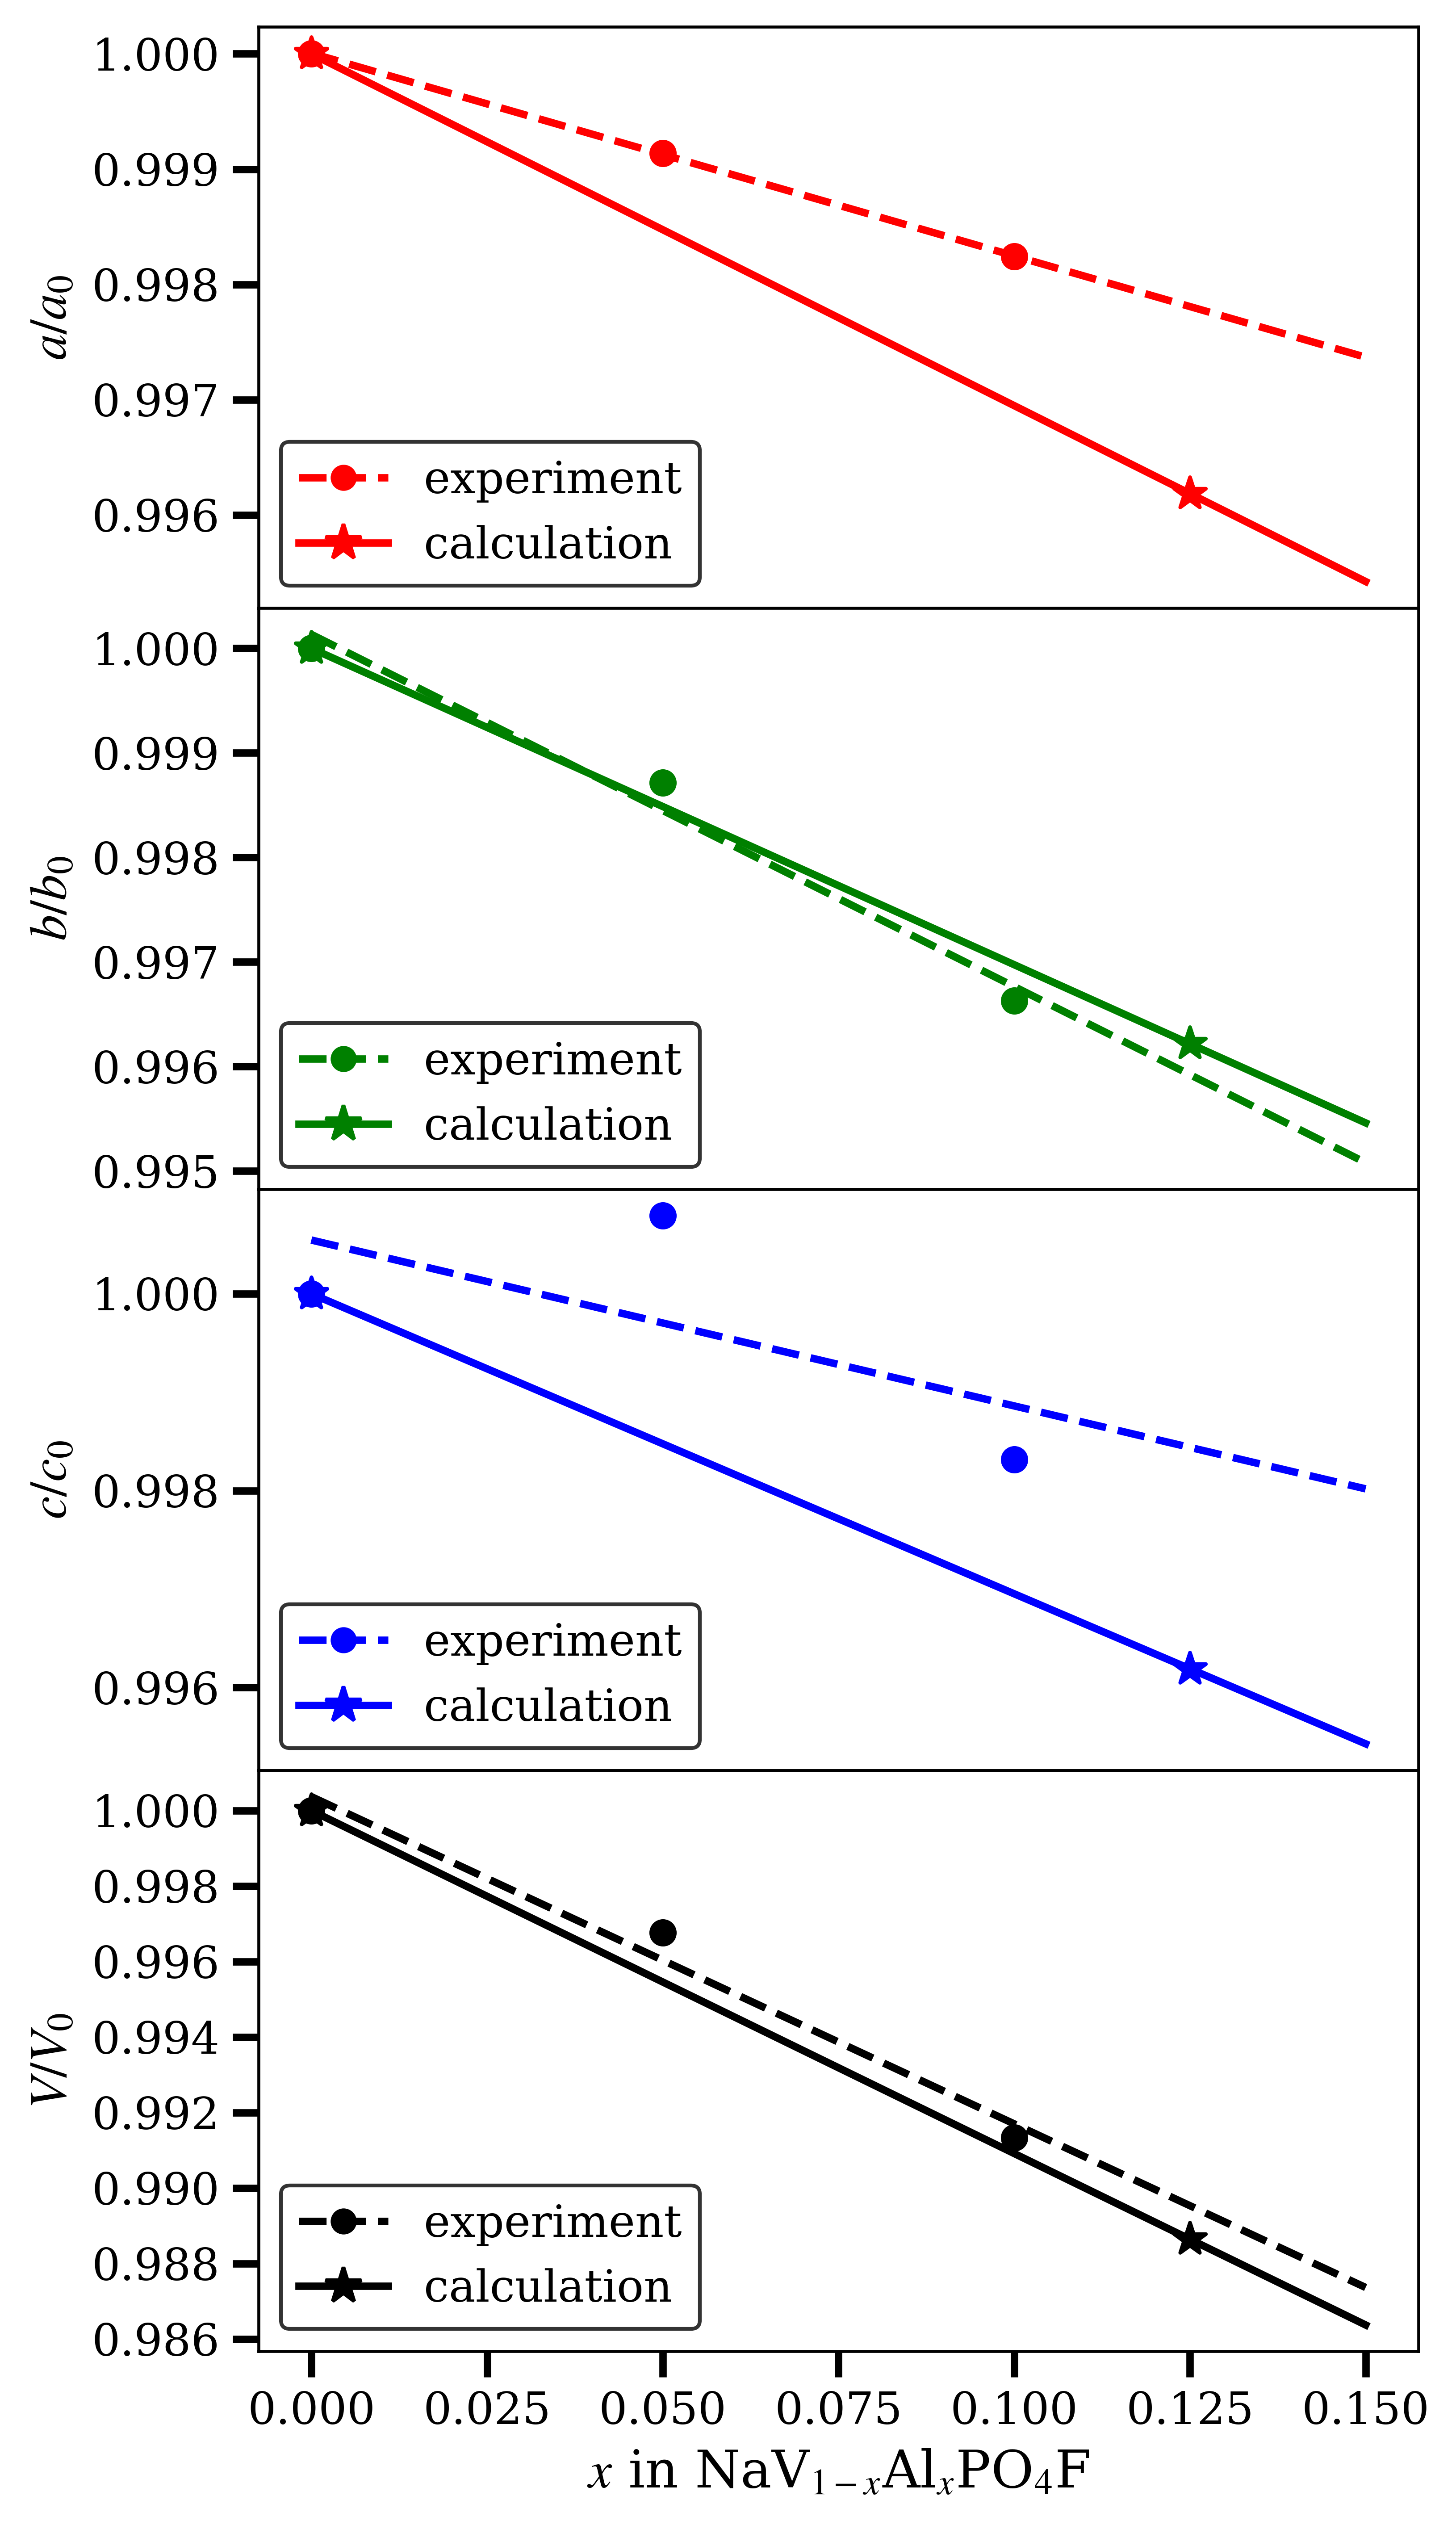

In [39]:
fontsize = 14
lw = 2.0
alpha = 0.35
x_fit = np.linspace(0, 0.15, 1000)

fig, ax = plt.subplots(4, 1, figsize=(6, 10), dpi=600)

for i in range(4):
    ax[i].locator_params(axis='x', nbins=8)
    if (i !=2):
        ax[i].locator_params(axis='y', nbins=8)
    else:
        ax[i].locator_params(axis='y', nbins=5)
        
    ax[i].set_ylabel(labels[i], fontsize=fontsize)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize-2)
    ax[i].tick_params(axis='both', which='minor', labelsize=fontsize-4)
    if (i != 3):
        ax[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[i].yaxis.get_offset_text().set_fontsize(10)
    ax[i].xaxis.set_tick_params(width=2, length=7)
    ax[i].yaxis.set_tick_params(width=2, length=7)
    
    coeffs = np.polyfit(ratios_exp, data_plot_exp[i], deg=1)  # degree 1 for linear
    y_fit = np.polyval(coeffs, x_fit)
    ax[i].plot(x_fit, y_fit, '--', color=colors[i], lw=lw, zorder=3)
    ax[i].scatter(ratios_exp, data_plot_exp[i], s=40, marker='o', color=colors[i], zorder=4)
    
    coeffs = np.polyfit(ratios_calc, data_plot_calc[i], deg=1)  # degree 1 for linear
    y_fit = np.polyval(coeffs, x_fit)
    ax[i].plot(x_fit, y_fit, '-', color=colors[i], lw=lw, zorder=3)
    ax[i].scatter(ratios_calc, data_plot_calc[i], s=80, marker='*', color=colors[i], )

    line_exp = Line2D([0], [0], linestyle='--', marker='o', color=colors[i], label="experiment", linewidth=2)
    line_calc = Line2D([0], [0], linestyle='-', marker='*', markersize=10, color=colors[i], label="calculation", linewidth=2)
    
    ax[i].legend(loc=3, fontsize=fontsize-2, edgecolor="black", handles=[line_exp, line_calc])


ax[3].set_xlabel(r'$x$ in NaV$_{1-x}$Al$_{x}$PO$_{4}$F', fontsize=fontsize)

plt.tight_layout()
plt.subplots_adjust(hspace=0.0)  # smaller values reduce horizontal padding

plt.show()

fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/ratios.png", dpi=600, bbox_inches='tight')
fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/ratios.pdf", dpi=600, bbox_inches='tight')



## Probability density maps

In [40]:
import mlyzed as md


In [41]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy.ma as ma

In [42]:
file_al = '/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al_dist.XDATCAR'          
file = '/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/inter.XDATCAR'        


In [ ]:
traj = md.Trajectory.from_file(file)
traj_al = md.Trajectory.from_file(file_al)



In [ ]:
traj.get_frame(0)

In [ ]:
p = md.probability_density(traj, specie = 'Na', resolution = 0.05)
p.write_grd('/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/inter.grd')


In [ ]:
p = md.probability_density(traj_al, specie = 'Na', resolution = 0.05)
p.write_grd('/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al_dist.grd')

## Voronoi volume analysis

In [43]:
def assign_particle_radii(frame, data):
    atom_types = data.particles_.particle_types_
    atom_types.type_by_id_(1).radius = 1.80  # Na
    atom_types.type_by_id_(2).radius = 1.35   # V 
    atom_types.type_by_id_(3).radius = 1.0  # P
    atom_types.type_by_id_(4).radius = 0.6  # O 
    atom_types.type_by_id_(5).radius = 0.5   # F
    

In [44]:
def assign_particle_radii_deinter(frame, data):
    atom_types = data.particles_.particle_types_
    atom_types.type_by_id_(1).radius = 1.35   # V 
    atom_types.type_by_id_(2).radius = 1.0  # P
    atom_types.type_by_id_(3).radius = 0.6  # O 
    atom_types.type_by_id_(4).radius = 0.5   # F
    

In [45]:
def assign_particle_radii_al(frame, data):
    atom_types = data.particles_.particle_types_
    atom_types.type_by_id_(1).radius = 1.80  # Na
    atom_types.type_by_id_(2).radius = 1.35   # V 
    atom_types.type_by_id_(3).radius = 1.0  # P
    atom_types.type_by_id_(4).radius = 0.6  # O 
    atom_types.type_by_id_(5).radius = 0.5   # F
    atom_types.type_by_id_(6).radius = 1.25   # Al
    

In [46]:
voro = VoronoiAnalysisModifier(
    compute_indices = False,
    use_radii = True,
    edge_threshold = 0.2
)


In [62]:
pipeline_inter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/inter.POSCAR")
pipeline_deinter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/deinter.POSCAR")
pipeline_some_na = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/some_na.POSCAR")

pipeline_al = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_dist.POSCAR")
pipeline_al_some_na = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_some_na.POSCAR")
pipeline_al_some_na_dead = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_some_na_dead.POSCAR")


In [63]:
pipeline_inter.modifiers.append(assign_particle_radii)
pipeline_inter.modifiers.append(voro)

pipeline_some_na.modifiers.append(assign_particle_radii)
pipeline_some_na.modifiers.append(voro)

pipeline_deinter.modifiers.append(assign_particle_radii_deinter)
pipeline_deinter.modifiers.append(voro)

pipeline_al.modifiers.append(assign_particle_radii_al)
pipeline_al.modifiers.append(voro)

pipeline_al_some_na.modifiers.append(assign_particle_radii_al)
pipeline_al_some_na.modifiers.append(voro)

pipeline_al_some_na_dead.modifiers.append(assign_particle_radii_al)
pipeline_al_some_na_dead.modifiers.append(voro)



In [69]:
data_inter = []
data_deinter = []
data_some_na = []
data_al = []
data_al_some_na = []
data_al_some_na_dead = []

# Evaluate the data pipeline for the current frame
data_inter = pipeline_inter.compute(0)
data_deinter = pipeline_deinter.compute(0)
data_some_na = pipeline_some_na.compute(0)
data_al = pipeline_al.compute(0)
data_al_some_na = pipeline_al_some_na.compute(0)
data_al_some_na_dead = pipeline_al_some_na_dead.compute(0)

# Get per-atom properties
voronoi_volumes_inter = data_inter.particles['Atomic Volume']
types_inter = data_inter.particles['Particle Type']
voronoi_volumes_deinter = data_deinter.particles['Atomic Volume']
types_deinter = data_deinter.particles['Particle Type']
voronoi_volumes_al = data_al.particles['Atomic Volume']
types_al = data_al.particles['Particle Type']
voronoi_volumes_al_some_na = data_al_some_na.particles['Atomic Volume']
types_al_some_na = data_al_some_na.particles['Particle Type']
voronoi_volumes_some_na = data_some_na.particles['Atomic Volume']
types_some_na = data_some_na.particles['Particle Type']
voronoi_volumes_al_some_na_dead = data_al_some_na_dead.particles['Atomic Volume']
types_al_some_na_dead = data_al_some_na_dead.particles['Particle Type']

# Select only Li atoms (type 1)
vol_inter = voronoi_volumes_inter[types_inter == 2]
vol_deinter = voronoi_volumes_deinter[types_deinter == 1]
vol_al = voronoi_volumes_al[types_al == 2]
vol_al_some_na = voronoi_volumes_al_some_na[types_al_some_na == 2]
vol_some_na = voronoi_volumes_some_na[types_some_na == 2]
vol_al_some_na_dead = voronoi_volumes_al_some_na_dead[types_al_some_na_dead == 2]

    

In [70]:
vol_inter


array([19.48793352, 19.4881783 , 19.48779665, 19.48788945, 20.02953977,
       20.02926451, 20.02948189, 20.02945319, 19.48765858, 19.48792237,
       19.48761317, 19.48768194, 20.02924813, 20.02933653, 20.02908058,
       20.02927259])

In [72]:
data = [vol_inter, vol_some_na, vol_deinter, vol_al, vol_al_some_na_dead, vol_al_some_na]

In [73]:
labels = [
    r"NaVPO$_4$F",
    r"Na$_{0.1}$VPO$_4$F",
    r"VPO$_4$F",
    
    r"NaV$_{0.9}$Al$_{0.1}$PO$_4$F",
    r"Na$_{0.2}$V$_{0.9}$Al$_{0.1}$PO$_4$F",
    r"Na$_{0.1}$V$_{0.9}$Al$_{0.1}$PO$_4$F",
]


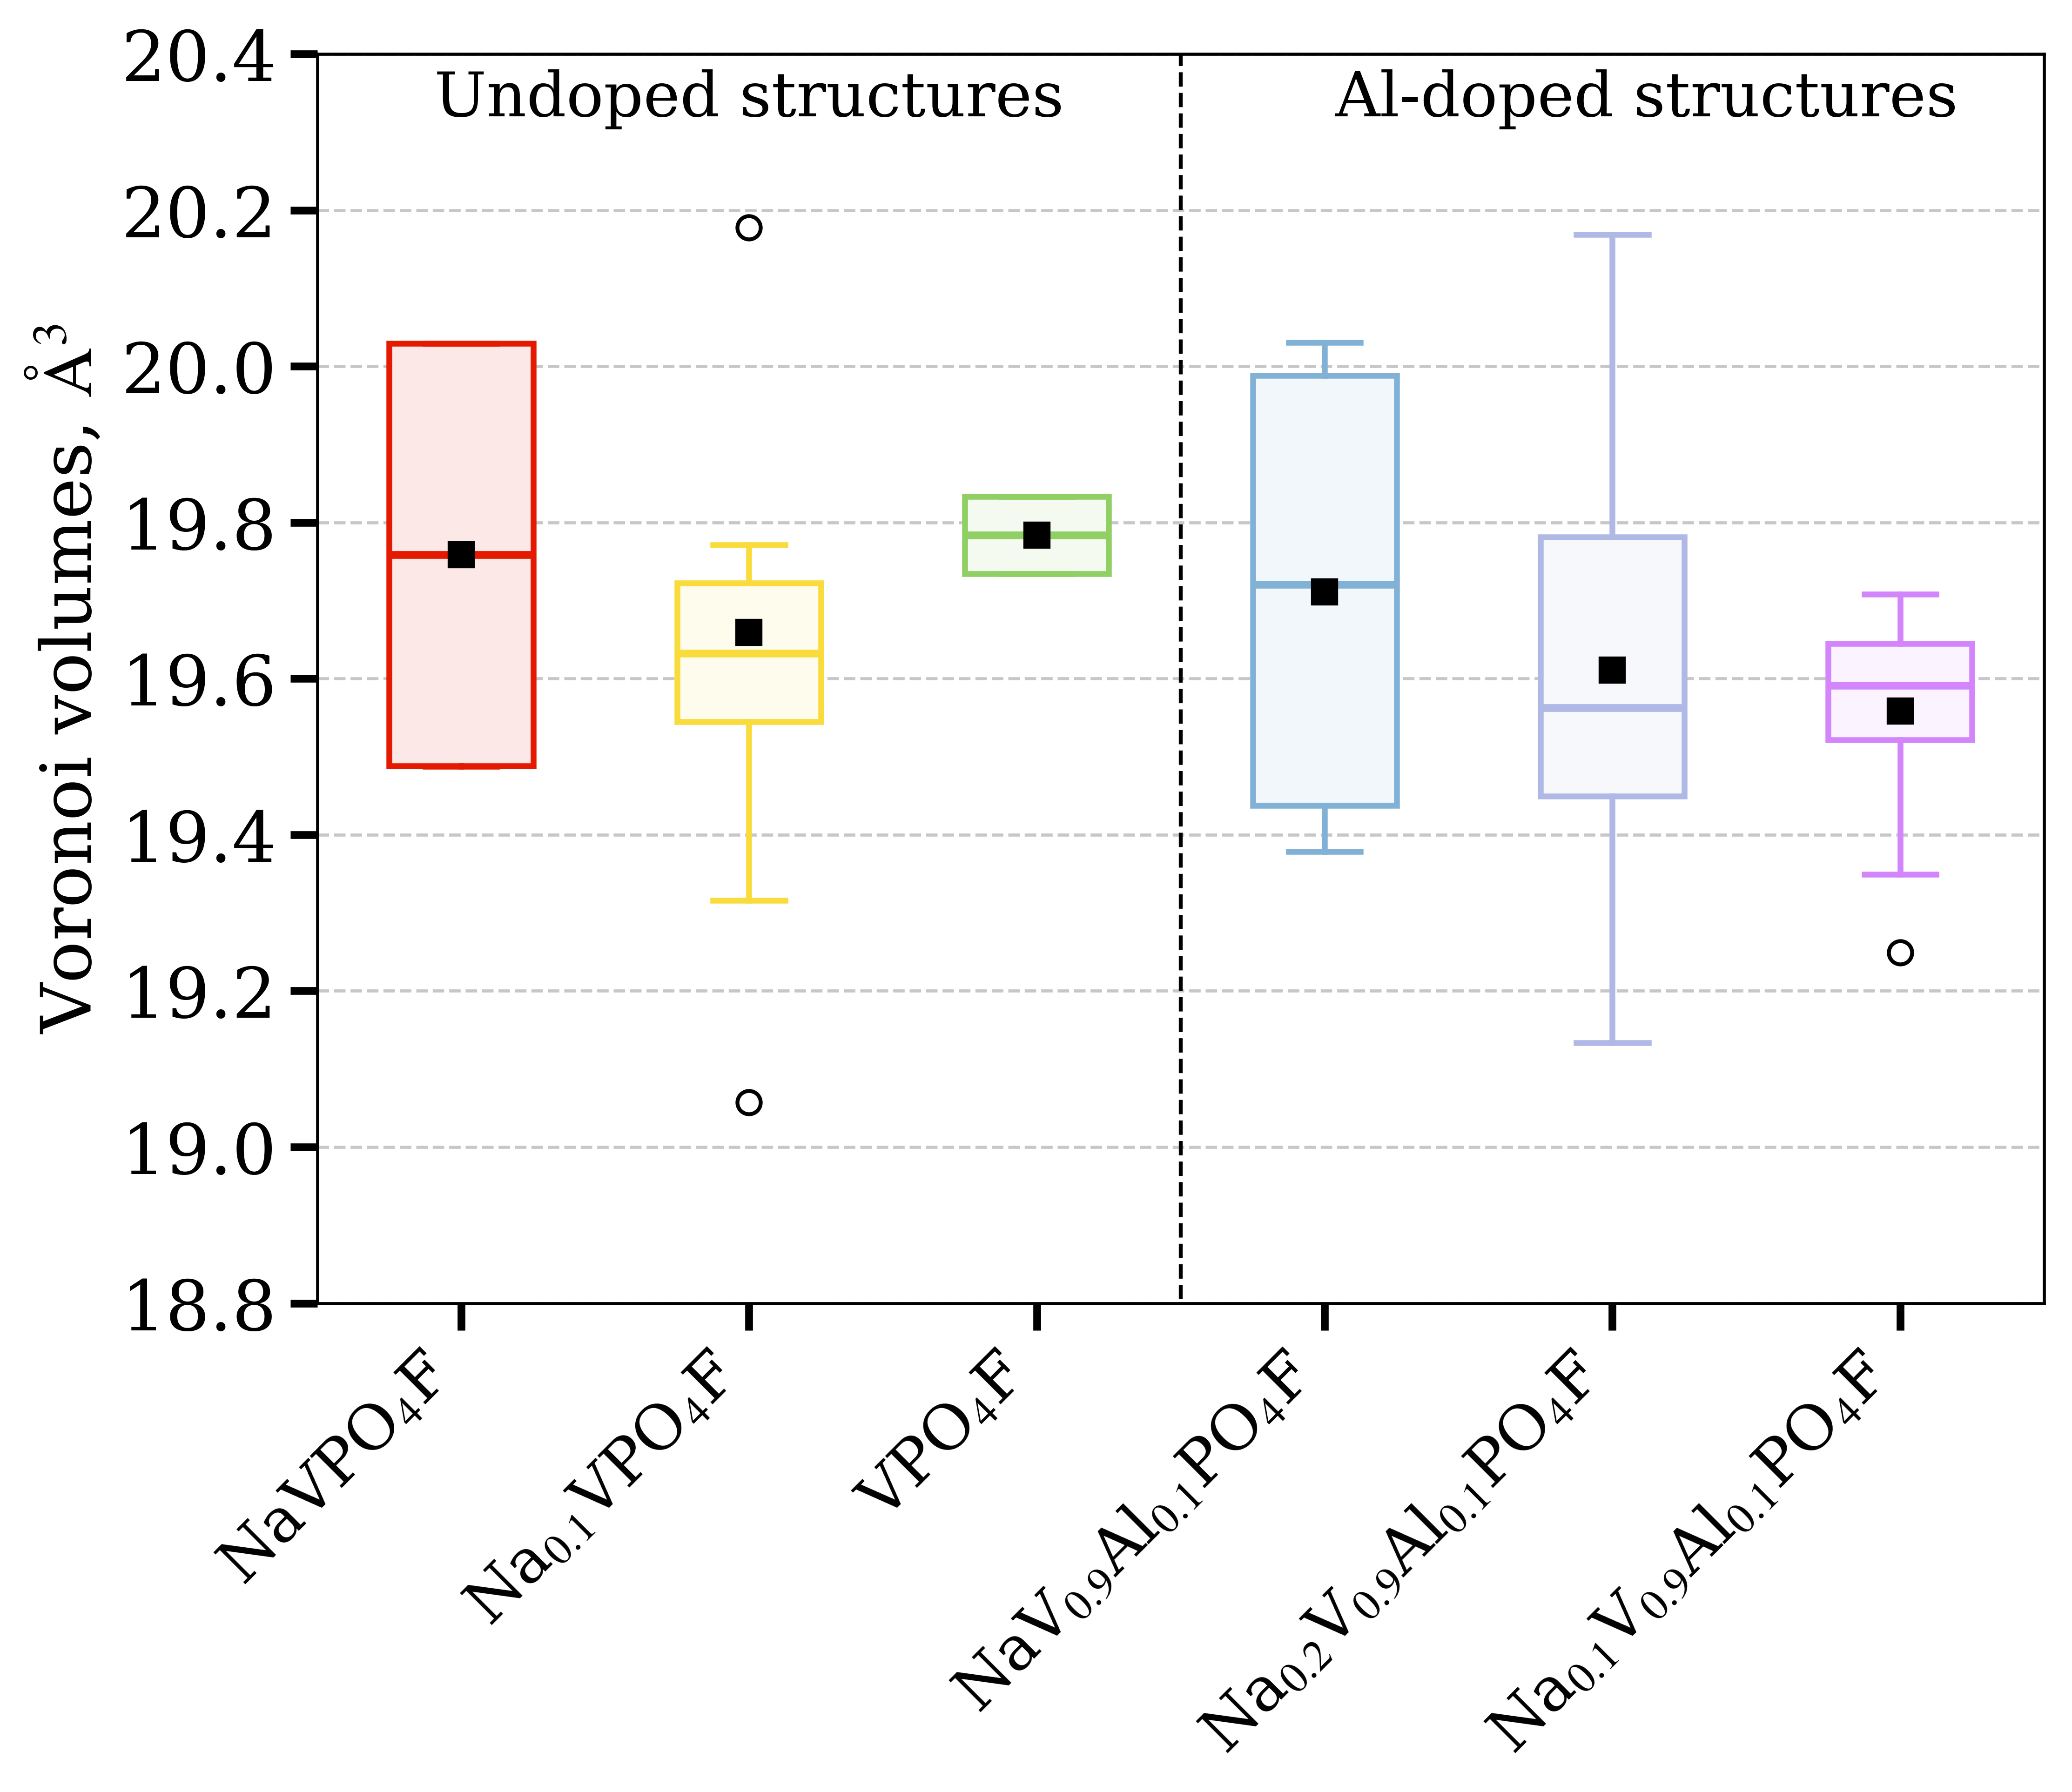

In [166]:
fontsize = 18
lw = 2.0
alpha = 0.1

fig, ax = plt.subplots(1, 1, figsize=(8, 7), dpi=600)
plt.tight_layout()

bp = ax.boxplot(data, patch_artist=True, showmeans=True, tick_labels=labels)

# Add titles and labels
ax.set_ylabel(r'Voronoi volumes, $\mathrm{\AA}^3$', fontsize=fontsize)
# ax.set_xlabel('Antisite defect type', fontsize=fontsize)

ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize-2)
ax.yaxis.get_offset_text().set_fontsize(10)
ax.xaxis.set_tick_params(width=2, length=7)
ax.yaxis.set_tick_params(width=2, length=7)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=fontsize-2)


# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)


mean_color = 'black'
# fill_color = blend_with_white(colors_rgb["red"], alpha=0.1)

# box_colors = ['red', 'blue', 'green']
box_colors = [colors_rgb['V'], colors_rgb['Na'], colors_rgb['L'], colors_rgb['Al'], colors_rgb['F'], colors_rgb['R'], ]
mean_color = 'black'
fill_color = 'pink'

colors_for_whiskers = []
for c in box_colors:
    colors_for_whiskers.extend([c, c])  # repeat each color twice (for each whisker and cap)

for whisker, color in zip(bp['whiskers'], colors_for_whiskers):
    whisker.set(color=color, linewidth=1.5)

for cap, color in zip(bp['caps'], colors_for_whiskers):
    cap.set(color=color, linewidth=1.5)
    
# Set box fill and edge colors

for patch, color in zip(bp['boxes'], box_colors ):
    color_fill = [cc*255 for cc in color]
    fill_color = blend_with_white(color_fill, alpha=0.1)
    fill_color = tuple([color_fill/255 for color_fill in fill_color])
    patch.set(facecolor=fill_color, edgecolor=color, linewidth=1.5)

# Set medians color
for median, color in zip(bp['medians'], box_colors):
    median.set(color=color, linewidth=2)

# Set means color and style
for mean in bp['means']:
    mean.set(marker='s', markeredgecolor=mean_color, markerfacecolor=mean_color, markersize=6)
    

ax.vlines(3.5, 18.0, 21, linestyles='--', color="black", lw=1)
ax.set_ylim([18.8, 20.4], )
# ax.text([18.8, 20.4], )
ax.text(0.25, 0.94, "Undoped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)
ax.text(0.77, 0.94, "Al-doped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)


plt.tight_layout()
plt.show()


fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/voronoi_volumes.png", dpi=600, bbox_inches='tight')
fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/voronoi_volumes.pdf", dpi=600, bbox_inches='tight')




In [168]:
for i in range(6):
    print(f"{np.mean(data[i]):.2f}", )

19.76
19.66
19.78
19.71
19.61
19.56


## Combined DOS plots

In [240]:
from scipy.ndimage import gaussian_filter1d


In [250]:
def load_data(file_path):
    data = np.loadtxt(file_path)
    energy = data[:, 0]
    # total_electrons = np.abs(data[:, 1]) + np.abs(data[:, 2])  # up + down electrons
    total_electrons = data[:, 1] + data[:, 2]  # up + down electrons
    
    return energy, total_electrons


In [225]:
data_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/dos/combined/inter/" 

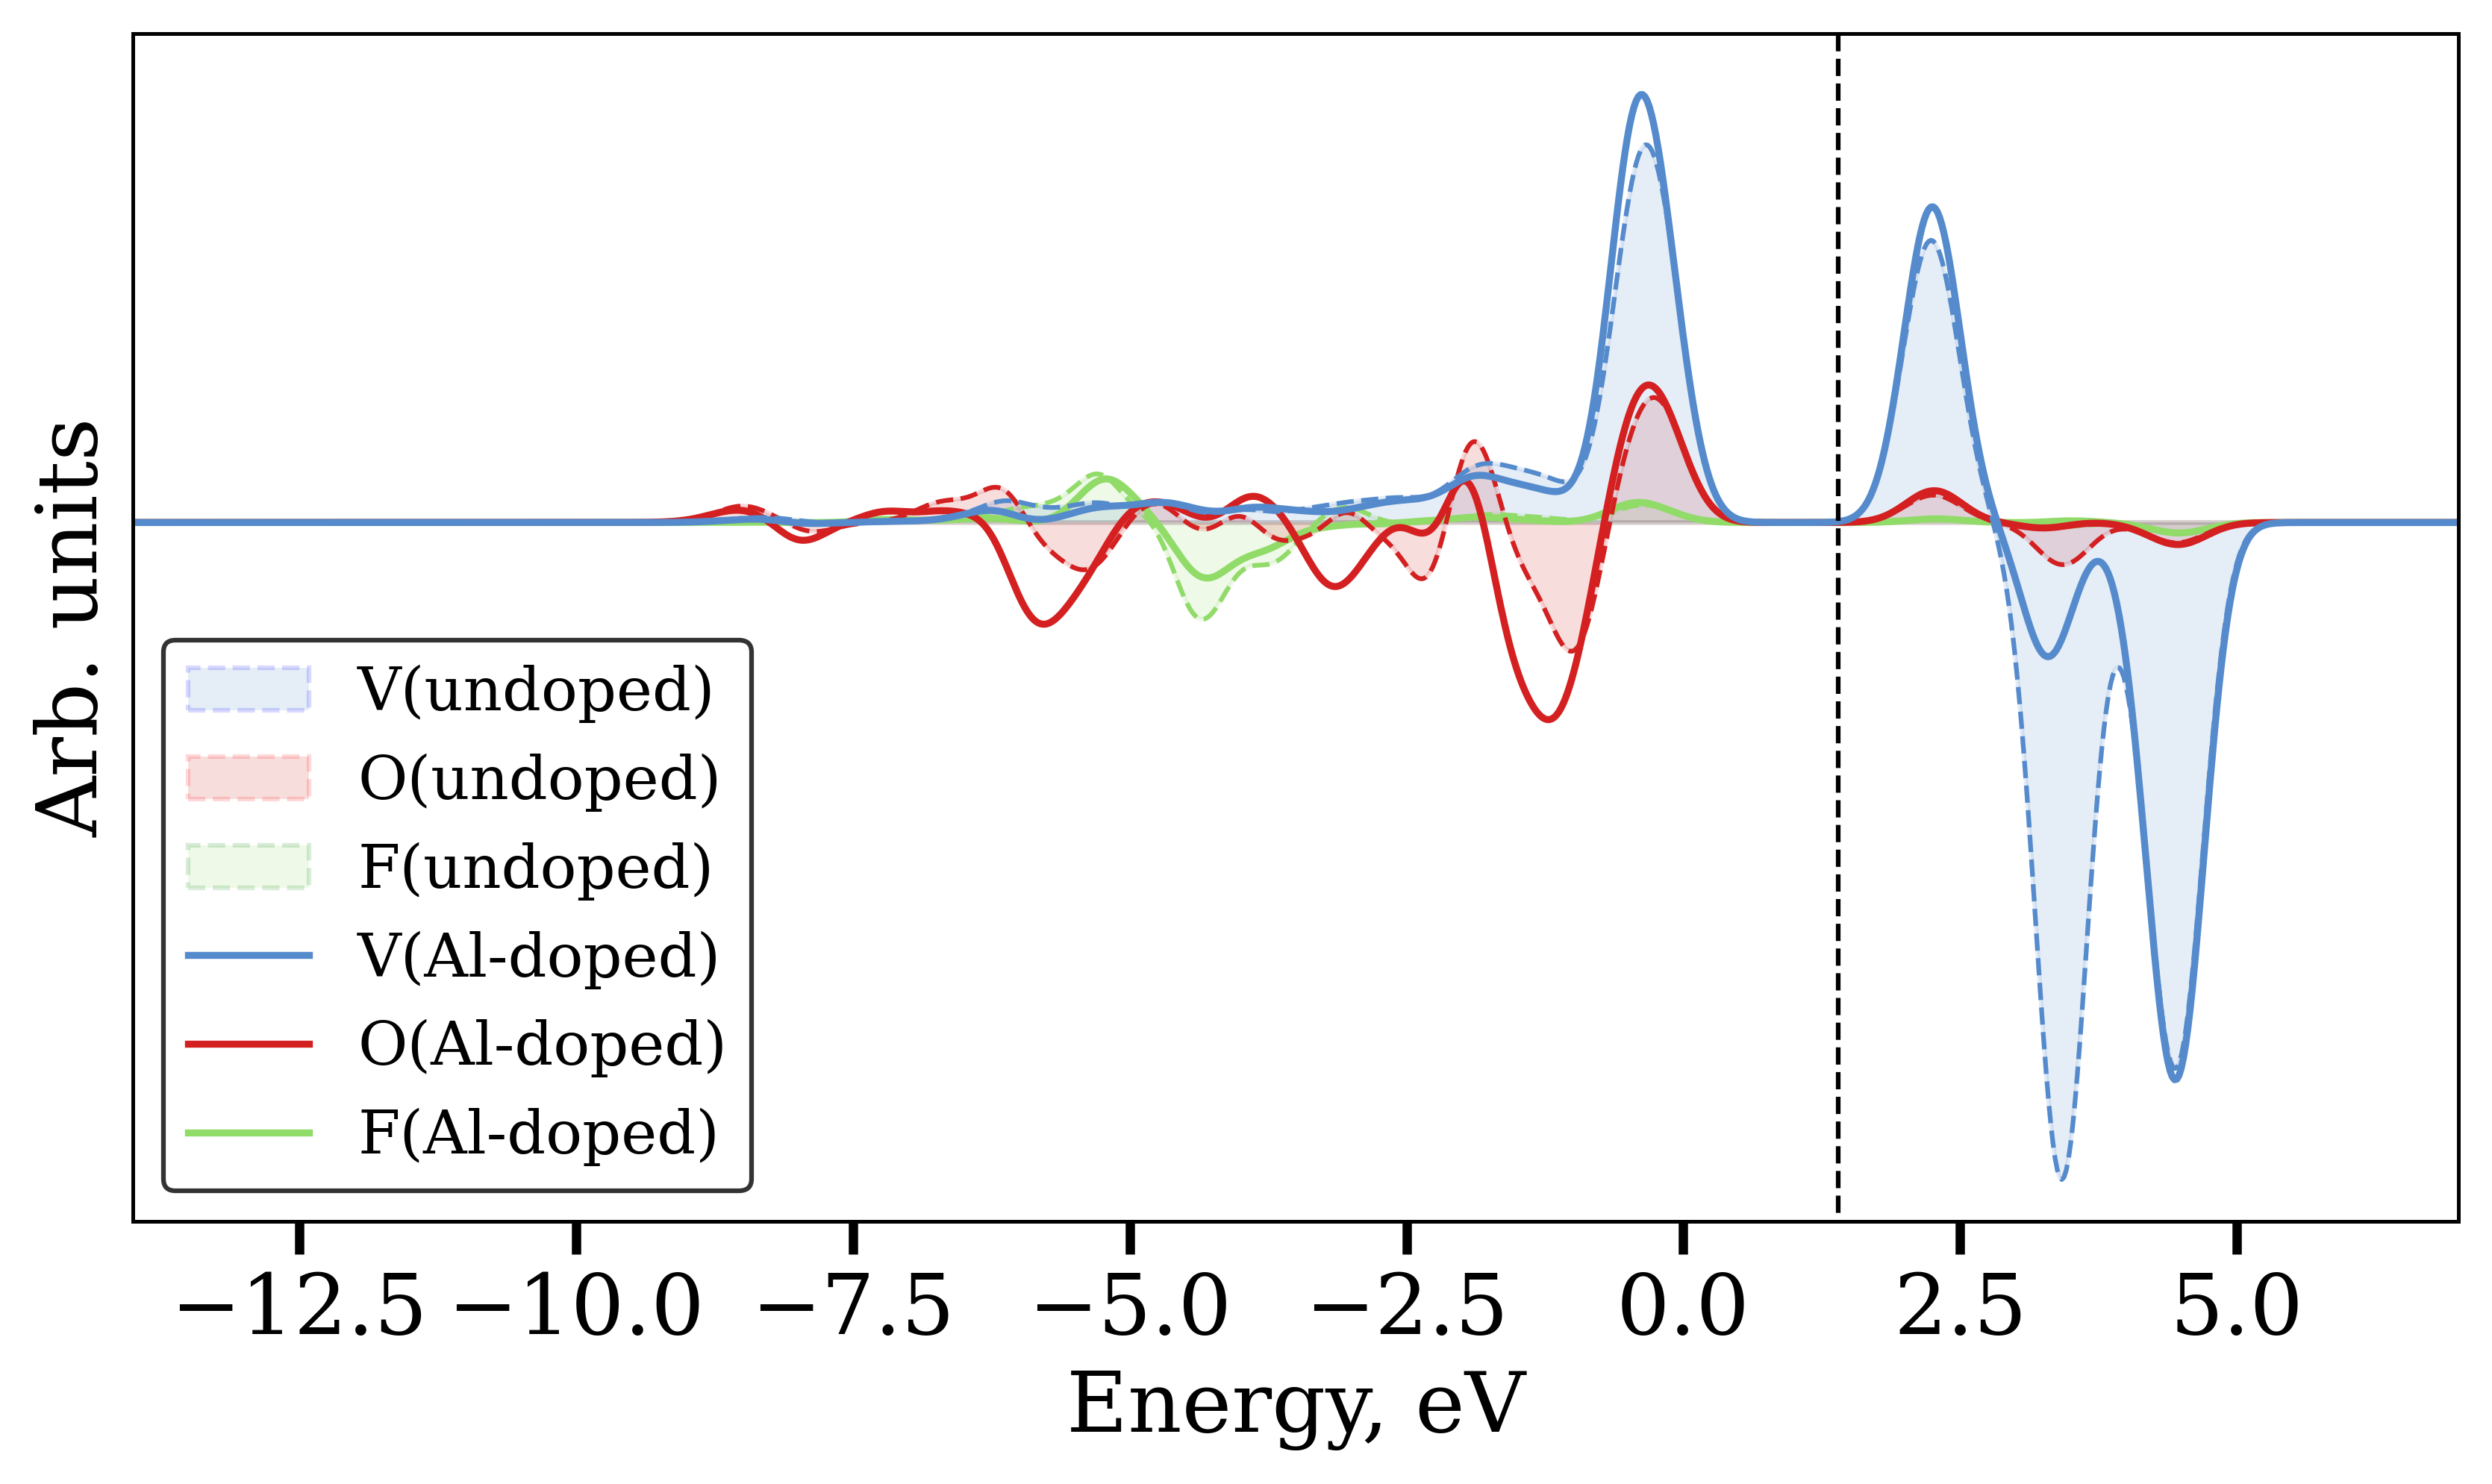

In [296]:

# List of data files in the directory
files = [
    "F_dos_al.dat",
    "F_dos_inter.dat",
    "O_dos_al.dat",
    "O_dos_inter.dat",
    "V_dos_al.dat",
    "V_dos_inter.dat"
]

files_deinter = [
    "F_dos_al.dat",
    "F_dos_inter.dat",
    "O_dos_al.dat",
    "O_dos_inter.dat",
    "V_dos_al.dat",
    "V_dos_inter.dat"
]

# Organize data by species and calculation type
species_data = {}
for file in files:
    species, calc_type_ext = file.split("_", 1)
    calc_type = calc_type_ext.split(".")[0]  # remove extension
    if species not in species_data:
        species_data[species] = {}
    file_path = os.path.join(data_path, file)
    energy, total_electrons = load_data(file_path)
    species_data[species][calc_type] = (energy, total_electrons)

# Plot the total electrons vs energy
fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=True)

fontsize = 18
sigma = 10  # Adjust sigma for smearing strength
alpha = 0.15

for i, (species, calculations) in enumerate(species_data.items()):
    for calc_type, (energy, total_electrons) in calculations.items():
        total_electrons_smooth = gaussian_filter1d(total_electrons, sigma=sigma)
        if "O" in species:
            color = colors_rgb["O_dos"]
        elif "V" in species:
            color = colors_rgb["V_dos"]
        elif "Al" in species:
            color = colors_rgb["Al_dos"]
        elif "F" in species:
            color = colors_rgb["F_dos"]
        
        if "inter" in calc_type:
            ax.plot(energy, total_electrons_smooth, '--', label=f"{calc_type}_{species}", lw=1, color=color)
            ax.fill_between(energy, total_electrons_smooth, 0, alpha=alpha, color=color)
        else:
            ax.plot(energy, total_electrons_smooth, label=f"{calc_type}_{species}", lw=1.5, color=color)
            
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize-2)
ax.yaxis.get_offset_text().set_fontsize(10)
ax.xaxis.set_tick_params(width=2, length=7)
ax.yaxis.set_tick_params(width=2, length=7)
ax.set_ylabel("Arb. units", fontsize=fontsize)
ax.set_xlabel("Energy, eV", fontsize=fontsize)
ax.set_yticks([])

ax.vlines(1.4, -100, 100, linestyle='--', color="black", lw=1)
ax.set_xlim([-14, 7])
ax.set_ylim([-50, 35])
# ax.set_ylim([-20, 20])

v_patch = mpatches.Rectangle((0, 0), 1, 1,  facecolor=colors_rgb["V_dos"], edgecolor="b", alpha=alpha,
                                linestyle='--',  linewidth=1, label=labels[0])
o_patch = mpatches.Rectangle((0, 0), 1, 1,  facecolor=colors_rgb["O_dos"], edgecolor="r", alpha=alpha,
                                linestyle='--',  linewidth=1, label=labels[0])
f_patch = mpatches.Rectangle((0, 0), 1, 1,  facecolor=colors_rgb["F_dos"], edgecolor="g", alpha=alpha,
                                linestyle='--',  linewidth=1, label=labels[0])
v_line = Line2D([0], [0], linestyle='-', color=colors_rgb["V_dos"], label=labels[1], linewidth=1.5)
o_line = Line2D([0], [0], linestyle='-', color=colors_rgb["O_dos"], label=labels[1], linewidth=1.5)
f_line = Line2D([0], [0], linestyle='-', color=colors_rgb["F_dos"], label=labels[1], linewidth=1.5)

patches = [v_patch, o_patch, f_patch, v_line, o_line, f_line]
labels = [
    "V(undoped)",
    "O(undoped)",
    "F(undoped)",
    "V(Al-doped)",
    "O(Al-doped)",
    "F(Al-doped)",
]


ax.legend(edgecolor="black", loc=3, handles=patches, labels=labels, fontsize=fontsize-5)

# ax.legend(loc=(1.15, 0.5), ncol=4,  handles=[gray_patch, red_line, blue_line, green_line], edgecolor="black", 
          # columnspacing=0.5, labelspacing=0.2,  fontsize=fontsize)

plt.tight_layout()
plt.show()


